# Part 2: Dataset Generation Pipeline

This notebook is the second part of our project. After training our diffusion model, we generated 500 synthetic persons. We now compose them with our backgrounds using this notebook.

### Prepare Required Files

We used CVAT for image annotation and need to convert cvat mask to numpy masks. 

In [ ]:
import json
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Find annotations file
anno_files = list(Path('background_with_masks').rglob('instances*.json'))
if len(anno_files) == 0:
    anno_files = list(Path('cvat_export').rglob('*.json'))

anno_file = anno_files[0]
print(f"✓ Found annotations: {anno_file}")

✓ Found annotations: background_with_masks\annotations\instances_default.json


In [ ]:
# Convert masks
print(" STEP 2: Converting CVAT RLE to NumPy Masks")

with open(anno_file) as f:
    coco_data = json.load(f)

print(f"\n Loaded COCO data:")
print(f"  Images: {len(coco_data['images'])}")
print(f"  Annotations: {len(coco_data['annotations'])}")

# Create directory to store converted masks
cache_dir = Path("segmentation_cache_cvat")
cache_dir.mkdir(exist_ok=True)

def rle_to_mask_fixed(rle_dict):
    """
    Convert CVAT RLE to binary mask
    
    CVAT RLE format:
    - counts: [run1, run2, run3, ...]
    - size: [height, width]
    - Encoded in COLUMN-MAJOR order (Fortran-style)
    """
    # Extract RLE components
    counts = rle_dict['counts']
    size = rle_dict['size']
    height, width = size
    
    # Create flat array
    mask_flat = np.zeros(height * width, dtype=np.uint8)
    
    # Initialize decoding variables
    position = 0
    value = 0  # Start with background
    
    for count in counts:
        # Fill current run
        mask_flat[position:position + count] = value
        position += count
        value = 1 - value  # Toggle
    
    # CRITICAL: Reshape in COLUMN-MAJOR order (Fortran style)
    mask = mask_flat.reshape((height, width), order='F')
    
    return mask

# Dictionary to store metadata about each processed image
metadata = {}
successful = 0

# Process each image in the dataset
for img_info in tqdm(coco_data['images']):
    # Extract image information
    img_id = img_info['id']
    img_name = img_info['file_name']
    height = img_info['height']
    width = img_info['width']
    
    # Initialize empty mask for this image
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Find all annotations that belong to this image
    img_annotations = [
        ann for ann in coco_data['annotations'] 
        if ann['image_id'] == img_id
    ]
    
    # Process each annotation for this image
    for ann in img_annotations:
        # Skip annotations without segmentation data
        if 'segmentation' not in ann:
            continue
        
        seg_data = ann['segmentation']
        
        # Check if segmentation is in RLE format (dict with 'counts' and 'size')
        if isinstance(seg_data, dict) and 'counts' in seg_data and 'size' in seg_data:
            try:
                # Decode RLE with fixed function
                ann_mask = rle_to_mask_fixed(seg_data)
                
                # Combine masks
                mask = np.maximum(mask, ann_mask)
                
            except Exception as e:
                print(f"\n  Error: {img_name}: {e}")
                continue
            
    # Count images that have at least some walkable area
    if mask.sum() > 0:
        successful += 1
    
    # Save mask as NumPy array
    np.save(cache_dir / f"{img_name}_mask.npy", mask)
    
    metadata[img_name] = {
        'walkable_pct': float(mask.mean() * 100),
        'shape': [height, width],
        'num_annotations': len(img_annotations)
    }

with open(cache_dir / "metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n{'='*70}")
print(f"✓ Converted {len(metadata)} masks")
print(f"  Successful: {successful}")
print(f"✓ Saved to: {cache_dir}/")

walkable_pcts = [m['walkable_pct'] for m in metadata.values()]

print(f"\nStatistics:")
print(f"  Average walkable: {np.mean(walkable_pcts):.1f}%")
print(f"  Range: {min(walkable_pcts):.1f}% - {max(walkable_pcts):.1f}%")
print(f"  Non-zero: {sum(1 for p in walkable_pcts if p > 0)}/{len(walkable_pcts)}")

 STEP 2: Converting CVAT RLE to NumPy Masks

 Loaded COCO data:
  Images: 100
  Annotations: 102


100%|██████████| 100/100 [00:01<00:00, 92.16it/s]


✓ Converted 100 masks
  Successful: 100
✓ Saved to: segmentation_cache_cvat/

Statistics:
  Average walkable: 18.3%
  Range: 2.0% - 66.5%
  Non-zero: 100/100


### Test on a sample 

Test: frame_006150.jpg
  Shape: (1080, 1920)
  Walkable: 22.5%
  Non-zero pixels: 465564


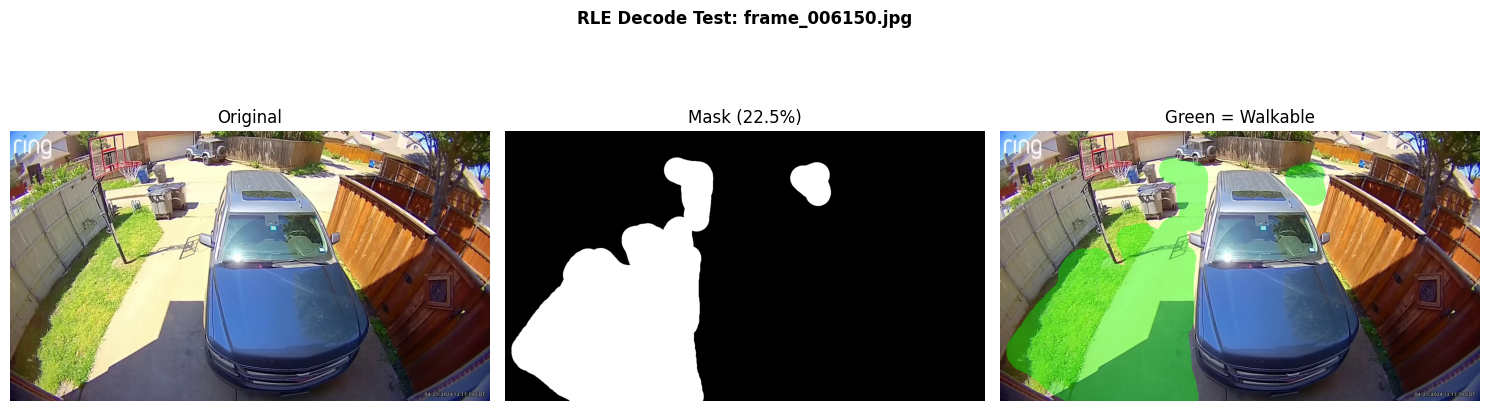

In [8]:
# Test one mask
import matplotlib.pyplot as plt

# Pick image
test_name = list(metadata.keys())[20]
test_mask = np.load(cache_dir / f"{test_name}_mask.npy")

print(f"Test: {test_name}")
print(f"  Shape: {test_mask.shape}")
print(f"  Walkable: {test_mask.mean()*100:.1f}%")
print(f"  Non-zero pixels: {test_mask.sum()}")

# Load image data/videos/frames (CHANGE PATH AS NEEDED)
img_path = Path('data/videos/frames') / test_name
if not img_path.exists():
    for ext in ['.jpg', '.png', '.jpeg', '.jfif', '.webp']:
        test_path = Path('data/videos/frames') / f"{Path(test_name).stem}{ext}"
        if test_path.exists():
            img_path = test_path
            break

if img_path.exists():
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Overlay
    overlay = img_rgb.copy()
    overlay[test_mask > 0] = overlay[test_mask > 0] * 0.6 + np.array([0, 255, 0]) * 0.4
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    axes[1].imshow(test_mask, cmap='gray')
    axes[1].set_title(f"Mask ({test_mask.mean()*100:.1f}%)")
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title("Green = Walkable")
    axes[2].axis('off')
    
    plt.suptitle(f"RLE Decode Test: {test_name}", fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\n⚠️  Image not found: {img_path}")

# COMPLETE PIPELINE - Persons → CCTV Backgrounds

Files are ready to use. Let's get start!

In [9]:
# TWO-CLASS HYBRID COMPOSITOR
# Class 0: Real persons (YOLO detected)
# Class 1: Synthetic persons (Generated)
"""
Benefits:
- Separate tracking of real vs synthetic
- Easy to merge later if needed
- Better analysis and debugging
- Flexible evaluation
"""

from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import glob
import random

## Resize Background and Masks


In [ ]:
import cv2
import glob
from pathlib import Path

def resize_background(background, target_resolution=(640, 480)):
    """
    Resize background to smaller resolution.
    
    Common CCTV resolutions:
    - (640, 480)   - VGA (classic CCTV)
    - (854, 480)   - FWVGA
    - (960, 540)   - qHD
    - (1280, 720)  - HD (original, too large)
    
    Args:
        background: Original background image
        target_resolution: (width, height) tuple
    
    Returns:
        Resized background
    """
    
    target_w, target_h = target_resolution
    
    background_resized = cv2.resize(
        background,
        (target_w, target_h),
        interpolation=cv2.INTER_AREA  # Best for downscaling
    )
    
    return background_resized

# Create output directory
Path("data/videos/frames_resized").mkdir(parents=True, exist_ok=True)

# Process all images
for bg_path in glob.glob("data/videos/frames/*"):
    bg_name = Path(bg_path).name
    bg = cv2.imread(bg_path)
    
    # Check if image loaded successfully
    if bg is None:
        print(f"⚠️  Failed to load: {bg_name}")
        continue
    
    bg_resized = resize_background(bg, target_resolution=(640, 480))
    cv2.imwrite(f"data/videos/frames_resized/{bg_name}", bg_resized)
    print(f"✓ Resized: {bg_name}")

print(f"\n✅ All backgrounds resized to 640×480!")

In [ ]:
import cv2
import numpy as np
import glob
from pathlib import Path

def resize_masks(
    masks_dir="segmentation_cache_cvat",
    output_dir="segmentation_cache_resized",
    target_resolution=(640, 480)
):
    """
    Resize segmentation masks to match resized backgrounds.
    
    CRITICAL: Masks must match background resolution!
    """
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    mask_files = sorted(glob.glob(f"{masks_dir}/*.npy"))
    
    target_w, target_h = target_resolution
    
    print(f"{'='*70}")
    print(f" RESIZING SEGMENTATION MASKS")
    print(f"{'='*70}")
    print(f"Target resolution: {target_w}×{target_h}")
    print(f"Total masks: {len(mask_files)}\n")
    
    for mask_file in mask_files:
        mask_name = Path(mask_file).name
        
        # Load mask
        mask = np.load(mask_file)
        original_h, original_w = mask.shape
        
        # Resize mask
        mask_resized = cv2.resize(
            mask.astype(np.uint8),
            (target_w, target_h),
            interpolation=cv2.INTER_NEAREST !
        )
        
        # Save resized mask
        np.save(output_path / mask_name, mask_resized)
        
        print(f"✓ {mask_name}: {original_w}×{original_h} → {target_w}×{target_h}")
    
    print(f"\n{'='*70}")
    print(f"✅ ALL MASKS RESIZED!")
    print(f"{'='*70}")
    print(f"Output: {output_dir}/")
    print(f"{'='*70}\n")


# RUN
resize_masks(
    masks_dir="segmentation_cache_cvat",
    output_dir="segmentation_cache_resized",
    target_resolution=(640, 480)
)

# YOLO After Composition Pipeline

This script implements an improved dataset generation pipeline that prevents mislabeling issues caused by overlapping real and synthetic persons.

## Pipeline Overview

**Order of Operations:**
1. **Compose** synthetic persons onto background images
2. **Detect** real persons using YOLO on the composited image
3. **Filter** YOLO detections to avoid duplicates with synthetic persons
4. **Label** both real (class 0) and synthetic (class 1) persons

## Why This Order Matters

Previously, we detected real persons first, then added synthetic ones. This caused mislabeling when synthetic and real persons overlapped. By compositing first and detecting second, we can properly identify and separate both classes.

## Key Features

### Adaptive Scaling
- Synthetic persons are scaled based on their position in the scene
- Persons further back (higher in image) appear smaller
- Automatic size adjustment based on person-to-background ratio

### Collision Prevention
- **IoU Check**: Prevents overlapping persons (default: 5% max overlap)
- **Distance Check**: Ensures minimum separation between persons (default: 60 pixels)
- **Duplicate Filtering**: Removes YOLO detections that overlap >30% with synthetic persons

## Output Classes

- **Class 0 (real_person)**: Real persons detected by YOLO after composition
- **Class 1 (synthetic_person)**: Synthetic persons placed via composition

## Configuration Parameters

| Parameter | Default | Description |
|-----------|---------|-------------|
| `yolo_conf` | 0.55 | YOLO detection confidence threshold |
| `max_iou` | 0.05 | Maximum allowed overlap between persons |
| `min_distance` | 60 | Minimum pixel distance between person centers |
| `persons_per_image` | (1, 3) | Random range of synthetic persons to place |

## Generated Output
```
final_yolo_scratch_after_dataset/
├── images/           # Composited images
├── labels/           # YOLO format labels (both classes)
├── dataset.yaml      # YOLO dataset configuration
└── metadata.json     # Generation statistics
```

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import glob
import random

class YOLOAfterCompositor:
    """
    New pipeline:
    1. Compose synthetic persons (class 1)
    2. Run YOLO on final image
    3. YOLO detections = real persons (class 0)
    4. Prevent duplicates on synthetic areas
    """
    
    def __init__(
        self,
        persons_dir,
        backgrounds_dir,
        masks_dir,
        output_dir,
        yolo_model_path='yolo11l.pt',
        yolo_conf=0.5,
        max_iou=0.05,
        min_distance=60
    ):
        self.persons_dir = Path(persons_dir)
        self.backgrounds_dir = Path(backgrounds_dir)
        self.masks_dir = Path(masks_dir)
        self.output_dir = Path(output_dir)
        self.max_iou = max_iou
        self.min_distance = min_distance   
        
        # Load YOLO
        self.yolo_model = YOLO(yolo_model_path)
        self.yolo_conf = yolo_conf
        
        (self.output_dir / "images").mkdir(parents=True, exist_ok=True)
        (self.output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        # Load assets
        self.person_paths = sorted(glob.glob(str(self.persons_dir / "*.png")))
        self.person_paths += sorted(glob.glob(str(self.persons_dir / "*.jpg")))
        
        self.bg_paths = sorted(glob.glob(str(self.backgrounds_dir / "*.jpg")))
        self.bg_paths += sorted(glob.glob(str(self.backgrounds_dir / "*.png")))
        self.bg_paths += sorted(glob.glob(str(self.backgrounds_dir / "*.jpeg")))
        self.bg_paths += sorted(glob.glob(str(self.backgrounds_dir / "*.jfif")))
        self.bg_paths += sorted(glob.glob(str(self.backgrounds_dir / "*.webp")))
        
        print(f"\n✓ YOLO-After Compositor:")
        print(f"  Synthetic persons: {len(self.person_paths)}")
        print(f"  Backgrounds: {len(self.bg_paths)}")
        print(f"  YOLO model: {yolo_model_path}")
        print(f"  YOLO confidence: {yolo_conf}")
        print(f"  Class 0: Real persons (YOLO)")
        print(f"  Class 1: Synthetic persons (Composed)")
    
    # [Include all helper methods from previous compositor]
    # remove_background, get_valid_placements, calculate_iou, etc.
    
    def remove_background(self, person_img):
        """Remove background from person."""
        try:
            from rembg import remove
            from PIL import Image
            
            person_pil = Image.fromarray(person_img)
            person_no_bg = remove(person_pil)
            person_no_bg = np.array(person_no_bg)
            
            if person_no_bg.shape[2] == 4:
                person_rgb = person_no_bg[:, :, :3]
                person_mask = (person_no_bg[:, :, 3] > 127).astype(np.uint8)
            else:
                person_rgb = person_no_bg
                person_mask = np.ones(person_rgb.shape[:2], dtype=np.uint8)
            
            return person_rgb, person_mask
        except:
            return person_img, np.ones(person_img.shape[:2], dtype=np.uint8)
        
    def get_adaptive_scale(self, person_height, person_width, bg_height, bg_width, foot_y):
        """Adaptive scaling helper."""
        
        person_height_ratio = person_height / bg_height
        base_scale = 0.5 + (foot_y / bg_height) * 0.20
        
        if person_height_ratio < 0.3:
            boost_factor = 2.0
        elif person_height_ratio < 0.5:
            boost_factor = 1.5
        else:
            boost_factor = 1.0
        
        adaptive_scale = base_scale * boost_factor
        adaptive_scale = np.clip(adaptive_scale, 0.8, 2.5)
        
        return adaptive_scale

    
    def get_valid_placements(self, walkable_mask, person_width, person_height, num_candidates=50):
        """
        Adaptive scaling based on person size.
        """
        
        h, w = walkable_mask.shape
        walkable_coords = np.argwhere(walkable_mask > 0)
        
        if len(walkable_coords) == 0:
            return []
        
        valid_placements = []
        attempts = 0
        
        while len(valid_placements) < num_candidates and attempts < num_candidates * 10:
            attempts += 1
            foot_y, foot_x = walkable_coords[random.randint(0, len(walkable_coords)-1)]
            
            # ADAPTIVE SCALING
            scale = self.get_adaptive_scale(
                person_height, person_width,
                h, w,
                foot_y
            )
            
            scaled_w = int(person_width * scale)
            scaled_h = int(person_height * scale)
            x = foot_x - scaled_w // 2
            y = foot_y - scaled_h
            
            margin = 10
            if (x >= margin and y >= margin and 
                x + scaled_w <= w - margin and y + scaled_h <= h - margin):
                
                foot_region = walkable_mask[
                    max(0, foot_y-10):min(h, foot_y+10),
                    max(0, foot_x-scaled_w//2):min(w, foot_x+scaled_w//2)
                ]
                if foot_region.mean() > 0.5:
                    valid_placements.append((x, y, scale))
        
        return valid_placements
    
    def get_actual_person_bbox(self, person_mask_resized, x_offset, y_offset):
        """Get tight bbox around person pixels."""
        person_pixels = np.argwhere(person_mask_resized > 0.5)
        
        if len(person_pixels) == 0:
            h, w = person_mask_resized.shape
            return (x_offset, y_offset, w, h)
        
        y_min = person_pixels[:, 0].min()
        y_max = person_pixels[:, 0].max()
        x_min = person_pixels[:, 1].min()
        x_max = person_pixels[:, 1].max()
        
        abs_x = x_offset + x_min
        abs_y = y_offset + y_min
        abs_w = x_max - x_min + 1
        abs_h = y_max - y_min + 1
        
        return (abs_x, abs_y, abs_w, abs_h)
    
    def calculate_iou(self, bbox1, bbox2):
        """
        Calculate how much two bounding boxes overlap.
        
        INPUT: Two bboxes as (x, y, width, height)
        OUTPUT: IoU value [0, 1]
        
        IoU = Area of Overlap / Area of Union
        
        Example:
        bbox1: Person 1 at (100, 200, 50, 150)
        bbox2: Person 2 at (120, 220, 50, 150)
        
        Intersection = 30 pixels × 130 pixels = 3,900 px²
        Union = 7,500 + 7,500 - 3,900 = 11,100 px²
        IoU = 3,900 / 11,100 = 0.35 (35% overlap)
        """
        
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        
        # Find overlap rectangle
        x_left = max(x1, x2)      # Leftmost edge of overlap
        y_top = max(y1, y2)       # Top edge of overlap
        x_right = min(x1+w1, x2+w2)  # Rightmost edge of overlap
        y_bottom = min(y1+h1, y2+h2) # Bottom edge of overlap
        
        # Check if boxes actually overlap
        if x_right < x_left or y_bottom < y_top:
            return 0.0  # No overlap
        
        # Calculate areas
        intersection = (x_right - x_left) * (y_bottom - y_top)
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def composite_person(self, person_img, person_mask, background, x, y, scale):
        """Composite person into background."""
        new_w = int(person_img.shape[1] * scale)
        new_h = int(person_img.shape[0] * scale)
        
        person_resized = cv2.resize(person_img, (new_w, new_h))
        mask_resized = cv2.resize(person_mask.astype(float), (new_w, new_h))
        
        mask_feathered = cv2.GaussianBlur(mask_resized, (15, 15), 0)
        
        bg_region = background[y:y+new_h, x:x+new_w].copy().astype(float)
        blended = (
            mask_feathered[..., None] * person_resized.astype(float) +
            (1 - mask_feathered[..., None]) * bg_region
        )
        
        result = background.copy()
        result[y:y+new_h, x:x+new_w] = blended.astype(np.uint8)
        
        actual_bbox = self.get_actual_person_bbox(mask_resized, x, y)
        
        return result, actual_bbox, mask_resized
    
    def calculate_distance(self, bbox1, bbox2):
        """
        Calculate distance between centers of two bboxes.
        
        Why needed? IoU only checks overlap, but persons can be
        too close without overlapping!
        
        Example:
        Person 1: █     Person 2:     █
                █                   █
                
        IoU = 0 (no overlap)
        But visually too close! ❌
        
        Distance check prevents this.
        """
        
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        
        # Calculate centers
        c1_x = x1 + w1 / 2
        c1_y = y1 + h1 / 2
        c2_x = x2 + w2 / 2
        c2_y = y2 + h2 / 2
        
        # Euclidean distance
        return np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)

    
    def detect_real_persons_avoid_synthetic(self, image, synthetic_bboxes, synthetic_masks_info):
        """
        Detect real persons with YOLO, avoiding synthetic areas.
        
        Args:
            image: Composited image (RGB)
            synthetic_bboxes: List of synthetic person bboxes (pixel coords)
            synthetic_masks_info: List of (x, y, mask) for synthetic persons
        
        Returns:
            List of real person bboxes (class 0)
        """
        
        h, w = image.shape[:2]
        
        # Run YOLO on final image
        results = self.yolo_model(
            image,
            classes=[0],  # Person class
            conf=self.yolo_conf,
            verbose=False
        )
        
        detections = results[0].boxes
        real_bboxes = []
        
        for box in detections:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            
            # Convert to (x, y, w, h)
            yolo_bbox = (int(x1), int(y1), int(x2-x1), int(y2-y1))
            
            # Check if this detection overlaps with synthetic persons
            is_duplicate = False
            
            for synthetic_bbox in synthetic_bboxes:
                iou = self.calculate_iou(yolo_bbox, synthetic_bbox)
                
                # If high overlap with synthetic → Skip (duplicate)
                if iou > 0.3:  # 30% overlap = duplicate
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                # This is a REAL person (not synthetic)
                real_bboxes.append(yolo_bbox)
        
        return real_bboxes
    
    def bbox_to_yolo(self, bbox, img_width, img_height, class_id):
        """Convert bbox to YOLO format."""
        x, y, w, h = bbox
        
        x_center = (x + w/2) / img_width
        y_center = (y + h/2) / img_height
        width = w / img_width
        height = h / img_height
        
        return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
    
    def generate_dataset(self, num_images=500, persons_per_image=(1, 3)):
        """
        Generate dataset with YOLO-after-composition.
        
        Pipeline:
        1. Compose synthetic persons
        2. Run YOLO on composited image
        3. Filter YOLO detections (avoid synthetic overlap)
        4. Save both classes
        """
        
        print(f"\n{'='*70}")
        print(f"Generating dataset with YOLO-AFTER-COMPOSITION...")
        print(f"{'='*70}\n")
        
        metadata = {
            'num_images': num_images,
            'pipeline': 'yolo_after_composition',
            'images': [],
            'stats': {
                'total_real': 0,
                'total_synthetic': 0,
                'images_with_real': 0,
                'images_with_synthetic': 0,
                'images_with_both': 0
            }
        }
        
        for i in tqdm(range(num_images), desc="Generating"):
            # Random background
            bg_path = random.choice(self.bg_paths)
            bg_name = Path(bg_path).name
            
            background = cv2.imread(bg_path)
            background_rgb = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
            
            # Load walkable mask
            mask_path = self.masks_dir / f"{bg_name}_mask.npy"
            if mask_path.exists():
                walkable_mask = np.load(mask_path)
            else:
                h, w = background.shape[:2]
                walkable_mask = np.zeros((h, w), dtype=np.uint8)
                walkable_mask[h//2:, :] = 1
            
            # STEP 1: COMPOSE SYNTHETIC PERSONS
            num_persons = random.randint(*persons_per_image)
            placed_bboxes = []
            placed_masks_info = []
            
            for p in range(num_persons):
                person_path = random.choice(self.person_paths)
                person = cv2.imread(person_path)
                person_rgb = cv2.cvtColor(person, cv2.COLOR_BGR2RGB)
                
                person_clean, person_mask = self.remove_background(person_rgb)
                
                person_h, person_w = person_clean.shape[:2]
                placements = self.get_valid_placements(walkable_mask, person_w, person_h, 50)
                
                if len(placements) == 0:
                    continue
                
                placed = False
                
                for x, y, scale in placements:
                    scaled_w = int(person_w * scale)
                    scaled_h = int(person_h * scale)
                    temp_bbox = (x, y, scaled_w, scaled_h)
                    
                    has_overlap = any(
                        self.calculate_iou(temp_bbox, existing) > self.max_iou or
                        self.calculate_distance(temp_bbox, existing) < self.min_distance
                        for existing in placed_bboxes
                    )
                    
                    if not has_overlap:
                        background_rgb, actual_bbox, mask_resized = self.composite_person(
                            person_clean, person_mask, background_rgb,
                            x, y, scale
                        )
                        
                        placed_bboxes.append(actual_bbox)
                        placed_masks_info.append((x, y, mask_resized))
                        placed = True
                        break
            
            # STEP 2: RUN YOLO ON COMPOSITED IMAGE
            real_bboxes = self.detect_real_persons_avoid_synthetic(
                background_rgb,
                placed_bboxes,
                placed_masks_info
            )
            
            # STEP 3: SAVE IMAGE
            img_filename = f"yolo_after_{i:05d}.jpg"
            cv2.imwrite(
                str(self.output_dir / "images" / img_filename),
                cv2.cvtColor(background_rgb, cv2.COLOR_RGB2BGR)
            )
            
            # STEP 4: SAVE LABELS (Real + Synthetic)
            with open(self.output_dir / "labels" / f"yolo_after_{i:05d}.txt", 'w') as f:
                # Write REAL person labels (class 0)
                for bbox in real_bboxes:
                    label = self.bbox_to_yolo(
                        bbox,
                        background.shape[1],
                        background.shape[0],
                        class_id=0  # Real
                    )
                    f.write(label + '\n')
                
                # Write SYNTHETIC person labels (class 1)
                for bbox in placed_bboxes:
                    label = self.bbox_to_yolo(
                        bbox,
                        background.shape[1],
                        background.shape[0],
                        class_id=1  # Synthetic
                    )
                    f.write(label + '\n')
            
            # Update stats
            num_real = len(real_bboxes)
            num_synthetic = len(placed_bboxes)
            
            metadata['stats']['total_real'] += num_real
            metadata['stats']['total_synthetic'] += num_synthetic
            
            if num_real > 0:
                metadata['stats']['images_with_real'] += 1
            if num_synthetic > 0:
                metadata['stats']['images_with_synthetic'] += 1
            if num_real > 0 and num_synthetic > 0:
                metadata['stats']['images_with_both'] += 1
            
            metadata['images'].append({
                'filename': img_filename,
                'source_bg': bg_name,
                'num_real': num_real,
                'num_synthetic': num_synthetic,
                'num_total': num_real + num_synthetic
            })
        
        # Save metadata
        with open(self.output_dir / "metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Create dataset.yaml
        dataset_yaml = f"""path: {self.output_dir.absolute()}
train: images
val: images

nc: 2
names: 
  0: real_person
  1: synthetic_person
"""
        with open(self.output_dir / "dataset.yaml", 'w') as f:
            f.write(dataset_yaml)
        
        # Print stats
        stats = metadata['stats']
        
        print(f"\n{'='*70}")
        print(f"✅ YOLO-AFTER DATASET COMPLETE!")
        print(f"{'='*70}")
        print(f"  Total images: {num_images}")
        print(f"  ")
        print(f"  Class 0 (Real - YOLO detected):")
        print(f"    Total: {stats['total_real']}")
        print(f"    Avg/image: {stats['total_real']/num_images:.1f}")
        print(f"    Images with real: {stats['images_with_real']}")
        print(f"  ")
        print(f"  Class 1 (Synthetic - Composed):")
        print(f"    Total: {stats['total_synthetic']}")
        print(f"    Avg/image: {stats['total_synthetic']/num_images:.1f}")
        print(f"    Images with synthetic: {stats['images_with_synthetic']}")
        print(f"  ")
        print(f"  Combined:")
        print(f"    Total persons: {stats['total_real'] + stats['total_synthetic']}")
        print(f"    Avg/image: {(stats['total_real'] + stats['total_synthetic'])/num_images:.1f}")
        print(f"    Images with both: {stats['images_with_both']}")
        print(f"  ")
        print(f"  Output: {self.output_dir}/")
        print(f"{'='*70}\n")
        
        return metadata


# RUN
compositor = YOLOAfterCompositor(
    persons_dir="generated_person_scratch/model_samples2",
    backgrounds_dir="data/videos/frames_resized",
    masks_dir="segmentation_cache_resized",
    output_dir="final_yolo_scratch_after_dataset",
    yolo_model_path='yolo11l.pt',
    yolo_conf=0.55,
    max_iou=0.05,
    min_distance=60
)

metadata = compositor.generate_dataset(
    num_images=500,
    persons_per_image=(1, 3)
)


✓ YOLO-After Compositor:
  Synthetic persons: 383
  Backgrounds: 98
  YOLO model: yolo11l.pt
  YOLO confidence: 0.55
  Class 0: Real persons (YOLO)
  Class 1: Synthetic persons (Composed)

Generating dataset with YOLO-AFTER-COMPOSITION...



Generating: 100%|██████████| 500/500 [39:34<00:00,  4.75s/it]


✅ YOLO-AFTER DATASET COMPLETE!
  Total images: 500
  
  Class 0 (Real - YOLO detected):
    Total: 147
    Avg/image: 0.3
    Images with real: 132
  
  Class 1 (Synthetic - Composed):
    Total: 1007
    Avg/image: 2.0
    Images with synthetic: 500
  
  Combined:
    Total persons: 1154
    Avg/image: 2.3
    Images with both: 132
  
  Output: final_yolo_scratch_after_dataset/



### Visulize Labels

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import random

def visualize_labels(
    dataset_dir="final_yolo_scratch_after_dataset",
    num_samples=10,
    random_sample=True,
    show_class_colors=True,
    save_output=True
):
    """
    Visualize bounding boxes for sample images.
    
    Args:
        dataset_dir: Path to dataset
        num_samples: Number of images to visualize
        random_sample: If True, random selection. If False, first N images
        show_class_colors: Different colors for class 0 vs class 1
        save_output: Save visualization as PNG
    """
    
    dataset_path = Path(dataset_dir)
    images_dir = dataset_path / "images"
    labels_dir = dataset_path / "labels"
    
    # Get all images
    image_paths = sorted(glob.glob(str(images_dir / "*.jpg")))
    
    if len(image_paths) == 0:
        print(f"❌ No images found in {images_dir}")
        return
    
    # Sample images
    if random_sample:
        sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))
    else:
        sample_paths = image_paths[:num_samples]
    
    # Create figure
    cols = 5
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(25, 5*rows))
    axes = axes.flatten() if num_samples > 1 else [axes]
    
    # Color scheme
    if show_class_colors:
        colors = {
            0: (255, 0, 0),    # Red for real persons (class 0)
            1: (0, 255, 0)     # Green for synthetic persons (class 1)
        }
        legend_text = "Red=Real | Green=Synthetic"
    else:
        colors = {0: (0, 255, 0), 1: (0, 255, 0)}  # All green
        legend_text = "Green=Person"
    
    print(f"{'='*70}")
    print(f" VISUALIZING {len(sample_paths)} IMAGES")
    print(f"{'='*70}\n")
    
    all_stats = {
        'total_real': 0,
        'total_synthetic': 0,
        'images_with_real': 0,
        'images_with_synthetic': 0,
        'images_with_both': 0
    }
    
    for idx, img_path in enumerate(sample_paths):
        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Get corresponding label file
        img_name = Path(img_path).stem
        label_path = labels_dir / f"{img_name}.txt"
        
        if not label_path.exists():
            print(f"⚠️  No label file for {img_name}")
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"{img_name}\nNo labels", fontsize=8)
            axes[idx].axis('off')
            continue
        
        # Parse labels
        num_real = 0
        num_synthetic = 0
        
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                
                class_id, xc, yc, wn, hn = map(float, parts)
                class_id = int(class_id)
                
                # Count
                if class_id == 0:
                    num_real += 1
                elif class_id == 1:
                    num_synthetic += 1
                
                # Convert YOLO to pixel coordinates
                x_center = xc * w
                y_center = yc * h
                box_width = wn * w
                box_height = hn * h
                
                x1 = int(x_center - box_width / 2)
                y1 = int(y_center - box_height / 2)
                x2 = int(x_center + box_width / 2)
                y2 = int(y_center + box_height / 2)
                
                # Draw bbox
                color = colors.get(class_id, (255, 255, 0))
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 3)
                
                # Draw class label
                label_text = f"C{class_id}"
                cv2.putText(
                    img_rgb, label_text,
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 2
                )
        
        # Update stats
        all_stats['total_real'] += num_real
        all_stats['total_synthetic'] += num_synthetic
        if num_real > 0:
            all_stats['images_with_real'] += 1
        if num_synthetic > 0:
            all_stats['images_with_synthetic'] += 1
        if num_real > 0 and num_synthetic > 0:
            all_stats['images_with_both'] += 1
        
        # Display
        title = f"{img_name}\n"
        if num_real > 0:
            title += f"Real: {num_real} | "
        if num_synthetic > 0:
            title += f"Synth: {num_synthetic}"
        title += f"\nTotal: {num_real + num_synthetic}"
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(title, fontsize=8)
        axes[idx].axis('off')
        
        # Print details
        print(f"[{idx+1}/{len(sample_paths)}] {img_name}")
        print(f"  Real persons: {num_real}")
        print(f"  Synthetic persons: {num_synthetic}")
        print(f"  Total: {num_real + num_synthetic}")
        print()
    
    # Hide unused subplots
    for idx in range(len(sample_paths), len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    plt.suptitle(
        f"Label Visualization - {legend_text}",
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout()
    
    # Save
    if save_output:
        output_path = "label_visualization.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved visualization: {output_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f" SUMMARY STATISTICS (Sample of {len(sample_paths)} images)")
    print(f"{'='*70}")
    print(f"  Real persons: {all_stats['total_real']}")
    print(f"  Synthetic persons: {all_stats['total_synthetic']}")
    print(f"  Total persons: {all_stats['total_real'] + all_stats['total_synthetic']}")
    print(f"  ")
    print(f"  Images with real: {all_stats['images_with_real']}")
    print(f"  Images with synthetic: {all_stats['images_with_synthetic']}")
    print(f"  Images with both: {all_stats['images_with_both']}")
    print(f"  ")
    print(f"  Avg real/image: {all_stats['total_real']/len(sample_paths):.1f}")
    print(f"  Avg synthetic/image: {all_stats['total_synthetic']/len(sample_paths):.1f}")
    print(f"  Avg total/image: {(all_stats['total_real']+all_stats['total_synthetic'])/len(sample_paths):.1f}")
    print(f"{'='*70}\n")


# DETAILED LABEL INSPECTOR
def inspect_labels_detailed(
    dataset_dir="final_yolo_scratch_after_dataset",
    num_samples=10
):
    """
    Detailed inspection: Show labels as text + bbox info.
    """
    
    dataset_path = Path(dataset_dir)
    images_dir = dataset_path / "images"
    labels_dir = dataset_path / "labels"
    
    image_paths = sorted(glob.glob(str(images_dir / "*.jpg")))
    sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))
    
    print(f"{'='*70}")
    print(f" DETAILED LABEL INSPECTION")
    print(f"{'='*70}\n")
    
    for idx, img_path in enumerate(sample_paths, 1):
        img_name = Path(img_path).stem
        label_path = labels_dir / f"{img_name}.txt"
        
        print(f"[{idx}] {img_name}")
        print(f"{'─'*70}")
        
        if not label_path.exists():
            print("  ⚠️  No label file\n")
            continue
        
        # Load image dimensions
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        print(f"  Image size: {w}×{h}")
        
        # Parse labels
        with open(label_path) as f:
            lines = f.readlines()
        
        if len(lines) == 0:
            print("  📝 Label file empty\n")
            continue
        
        print(f"  Persons: {len(lines)}\n")
        
        for i, line in enumerate(lines, 1):
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"    {i}. ⚠️  Invalid format: {line.strip()}")
                continue
            
            class_id, xc, yc, wn, hn = map(float, parts)
            class_id = int(class_id)
            
            # Convert to pixels
            x_center_px = xc * w
            y_center_px = yc * h
            width_px = wn * w
            height_px = hn * h
            
            # Calculate corners
            x1 = int(x_center_px - width_px / 2)
            y1 = int(y_center_px - height_px / 2)
            x2 = int(x_center_px + width_px / 2)
            y2 = int(y_center_px + height_px / 2)
            
            # Display
            class_name = "Real" if class_id == 0 else "Synthetic"
            print(f"    Person {i} [{class_name}]:")
            print(f"      YOLO format:  class={class_id} xc={xc:.3f} yc={yc:.3f} w={wn:.3f} h={hn:.3f}")
            print(f"      Pixel coords: ({x1}, {y1}) → ({x2}, {y2})")
            print(f"      Bbox size:    {int(width_px)}×{int(height_px)} pixels")
            print(f"      Center:       ({int(x_center_px)}, {int(y_center_px)})")
            print()
        
        print()


# LABEL STATISTICS
def analyze_labels_statistics(dataset_dir="final_twoclass_dataset"):
    """
    Compute comprehensive statistics across entire dataset.
    """
    
    dataset_path = Path(dataset_dir)
    labels_dir = dataset_path / "labels"
    
    label_files = sorted(glob.glob(str(labels_dir / "*.txt")))
    
    if len(label_files) == 0:
        print("❌ No label files found")
        return
    
    stats = {
        'total_images': len(label_files),
        'images_with_labels': 0,
        'total_persons': 0,
        'total_real': 0,
        'total_synthetic': 0,
        'persons_per_image': [],
        'real_per_image': [],
        'synthetic_per_image': [],
        'bbox_areas': [],
        'bbox_aspect_ratios': []
    }
    
    print(f"{'='*70}")
    print(f" ANALYZING {len(label_files)} LABEL FILES")
    print(f"{'='*70}\n")
    
    for label_path in label_files:
        with open(label_path) as f:
            lines = f.readlines()
        
        if len(lines) == 0:
            continue
        
        stats['images_with_labels'] += 1
        
        num_real = 0
        num_synthetic = 0
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            
            class_id, xc, yc, wn, hn = map(float, parts)
            class_id = int(class_id)
            
            stats['total_persons'] += 1
            
            if class_id == 0:
                num_real += 1
                stats['total_real'] += 1
            elif class_id == 1:
                num_synthetic += 1
                stats['total_synthetic'] += 1
            
            # Bbox statistics
            area = wn * hn  # Normalized area
            aspect_ratio = hn / wn if wn > 0 else 0
            
            stats['bbox_areas'].append(area)
            stats['bbox_aspect_ratios'].append(aspect_ratio)
        
        stats['persons_per_image'].append(num_real + num_synthetic)
        stats['real_per_image'].append(num_real)
        stats['synthetic_per_image'].append(num_synthetic)
    
    # Print statistics
    print(f"DATASET OVERVIEW:")
    print(f"  Total images: {stats['total_images']}")
    print(f"  Images with labels: {stats['images_with_labels']}")
    print(f"  Empty images: {stats['total_images'] - stats['images_with_labels']}")
    print()
    
    print(f"PERSON COUNTS:")
    print(f"  Total persons: {stats['total_persons']}")
    print(f"  Real persons: {stats['total_real']} ({stats['total_real']/stats['total_persons']*100:.1f}%)")
    print(f"  Synthetic persons: {stats['total_synthetic']} ({stats['total_synthetic']/stats['total_persons']*100:.1f}%)")
    print()
    
    print(f"AVERAGES:")
    print(f"  Persons per image: {np.mean(stats['persons_per_image']):.2f} ± {np.std(stats['persons_per_image']):.2f}")
    print(f"  Real per image: {np.mean(stats['real_per_image']):.2f} ± {np.std(stats['real_per_image']):.2f}")
    print(f"  Synthetic per image: {np.mean(stats['synthetic_per_image']):.2f} ± {np.std(stats['synthetic_per_image']):.2f}")
    print()
    
    print(f"BOUNDING BOX STATISTICS:")
    print(f"  Avg area (normalized): {np.mean(stats['bbox_areas']):.4f}")
    print(f"  Avg aspect ratio (h/w): {np.mean(stats['bbox_aspect_ratios']):.2f}")
    print(f"  Min aspect ratio: {np.min(stats['bbox_aspect_ratios']):.2f}")
    print(f"  Max aspect ratio: {np.max(stats['bbox_aspect_ratios']):.2f}")
    print(f"{'='*70}\n")
    
    # Histograms
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Persons per image
    axes[0, 0].hist(stats['persons_per_image'], bins=range(0, max(stats['persons_per_image'])+2), edgecolor='black')
    axes[0, 0].set_xlabel('Persons per Image')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Persons per Image')
    axes[0, 0].grid(alpha=0.3)
    
    # Real vs Synthetic
    axes[0, 1].bar(['Real', 'Synthetic'], [stats['total_real'], stats['total_synthetic']])
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Real vs Synthetic Persons')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # Bbox areas
    axes[1, 0].hist(stats['bbox_areas'], bins=50, edgecolor='black')
    axes[1, 0].set_xlabel('Normalized Bbox Area')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Bbox Areas')
    axes[1, 0].grid(alpha=0.3)
    
    # Aspect ratios
    axes[1, 1].hist(stats['bbox_aspect_ratios'], bins=50, edgecolor='black')
    axes[1, 1].set_xlabel('Aspect Ratio (height/width)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Aspect Ratios')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('label_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()  
    
    print("✓ Saved statistics: label_statistics.png\n")
    
    return stats


# RUN ALL INSPECTIONS

# 1. Visual inspection (10 samples)
visualize_labels(
    dataset_dir="final_yolo_scratch_after_dataset",
    num_samples=10,
    random_sample=True,
    show_class_colors=True,
    save_output=True
)

# 2. Detailed text inspection
inspect_labels_detailed(
    dataset_dir="final_yolo_scratch_after_dataset",
    num_samples=10
)

# 3. Full dataset statistics
stats = analyze_labels_statistics(
    dataset_dir="final_yolo_scratch_after_dataset"
)